### ライブラリのインポート

In [1]:
import os
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import MixtureSameFamily, Categorical

In [3]:
# 乱数シードを固定
torch.manual_seed(1234)

### サンプリングしたい確率分布の定義

In [4]:
# 平均ベクトル
means = torch.tensor([[2.0, 2.0], [-2.0, -2.0]])

# 共分散行列
covs = torch.Tensor([
    [[ 1.0,  0.0],
     [ 0.0,  1.0]],
    [[ 1.0,  0.0],
     [ 0.0,  1.0]],
])

# 混合係数
mixture_weights = torch.tensor([0.5, 0.5])

# 混合正規分布を作成
dist = MixtureSameFamily(
    Categorical(mixture_weights),
    MultivariateNormal(means, covs)
)

In [5]:
# 二次元の格子点の座標を作成
ls = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(ls, ls)
point = torch.tensor(np.vstack([x.flatten(), y.flatten()]).T)
# 格子点の座標における尤度を算出
p = torch.exp(dist.log_prob(point))

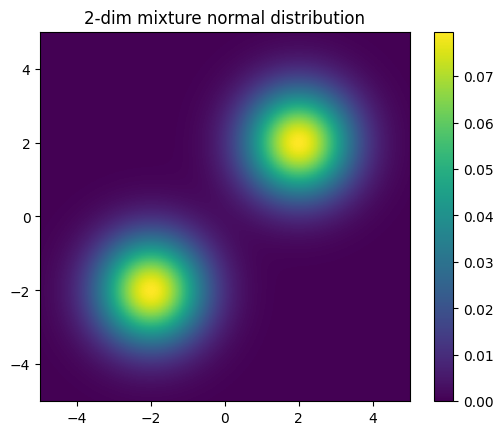

In [6]:
# 混合分布を可視化
plt.title('2-dim mixture normal distribution')
plt.pcolormesh(x, y, p.reshape(x.shape), cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.colorbar()
plt.show()

### スコアベースモデルの学習

In [7]:
# 学習するニューラルネットワークモデルを定義
# 今回はシンプルな4層の全結合層からなるモデルを定義
class ScoreBaseModel(nn.Module):
    def __init__(self, input_dim, mid_dim=64):
        super().__init__()
        self.input_dim = input_dim
        self.mid_dim = mid_dim
        self.fc1 = nn.Linear(input_dim+1, mid_dim)
        self.fc2 = nn.Linear(mid_dim, mid_dim//2)
        self.fc3 = nn.Linear(mid_dim//2, mid_dim//4)
        self.fc4 = nn.Linear(mid_dim//4, input_dim)
        return
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [8]:
# 学習用の関数を定義
def train(batch_size, num_epoch, dist, model, optimizer, criterion):
    
    # EpochごとのLossを保存するリスト
    out_list = []
    # モデルを学習モードに変更
    model.train()
    # 以下num_epoch回数分の学習を実行
    for epoch in tqdm(range(num_epoch)):
        
        # 確率分布からBatch Size分だけサンプリング
        sample = dist.sample((batch_size,))
        # サンプリング結果に付加するするノイズの標準偏差を一様分布から取得（0~10の範囲）
        sigma = torch.rand(1) * 10
        # サンプリング結果に付加するノイズを平均0、標準偏差Sigmaで生成
        noise = torch.normal(mean=0, std=sigma.item(), size=sample.shape)
        # サンプリング結果にノイズ付加
        noise_sample = sample + noise
        # モデルの予測対象を計算
        true_y = - noise / sigma / sigma
        # Sigmaをモデルに入力できるように(Batch Size, 1)の形状に変換
        batch_sigma = torch.ones((batch_size, 1)) * sigma
        
        # ノイズ付加後のサンプリング結果とSigmaをConcatで結合
        x = torch.concat([noise_sample, batch_sigma], axis=1)
        # それらをモデルに入力して予測を実行
        pred_y = model(x)
        
        # 勾配情報を初期化
        optimizer.zero_grad()
        # Lossの計算
        # SigmaごとにLossの水準を
        loss = criterion(true_y, pred_y) * sigma * sigma
        # 誤差逆伝播法で勾配計算
        loss.backward()
        # 計算された勾配に基づいてモデルパラメータの更新
        optimizer.step()
        
        # EpochごとのLossをリストに追加
        out_list.append([
            epoch,
            loss.item(),
        ])
    
    df_res = pd.DataFrame(out_list, columns=['epoch','loss'])
    return df_res

In [9]:
# 学習時のパラメータを設定
input_dim = 2
lr = 0.001
batch_size = 2000
num_epoch = 10000

In [10]:
# モデル作成
model = ScoreBaseModel(input_dim)
# モデルパラメータの最適化手法を決定
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Loss関数を決定
criterion = torch.nn.MSELoss()

In [11]:
# 学習の実行
df_res = train(batch_size, num_epoch, dist, model, optimizer, criterion)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

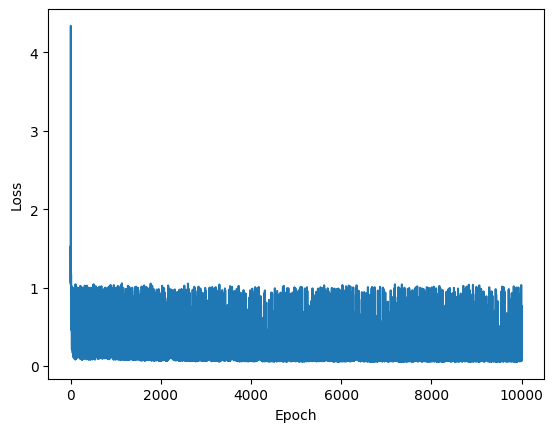

In [12]:
# Lossの推移を可視化
df_res['loss'].plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')

### 学習されたスコアの可視化

In [13]:
# 確率分布のスコアを計算する関数を定義
def calc_score(dist, x):
    # xを自動微分対象に変更
    x.requires_grad_()
    # 対数尤度を計算
    log_p = dist.log_prob(x)
    # 対数尤度のxによる微分を計算
    score = torch.autograd.grad(log_p.sum(), x)[0]
    return score

In [14]:
# 二次元の格子点の座標を作成
num_point = 20
ls = np.linspace(-5, 5, num_point)
x, y = np.meshgrid(ls, ls)
point = torch.tensor(np.vstack([x.flatten(), y.flatten()]).T).to(torch.float32)

In [15]:
# 格子点における混合分布のスコアを計算
score = calc_score(dist, point)
# 可視化のため、(x座標,y座標,スコアの値)の形状に変換
score = score.reshape((num_point,num_point,input_dim))

In [16]:
# sigma=1として格子点におけるスコアを予測
sigma = 1
noise = torch.normal(mean=0, std=sigma, size=point.shape)
noise_sample = point + noise
batch_sigma = torch.ones((noise_sample.shape[0], 1)) * sigma

# モデルを推論モードに変更
model.eval()
with torch.no_grad():
    pred_y = model(torch.concat([noise_sample, batch_sigma], axis=1))
# 可視化のため、(x座標,y座標,スコアの値)の形状に変換
pred_vec = pred_y.reshape((num_point,num_point,input_dim))

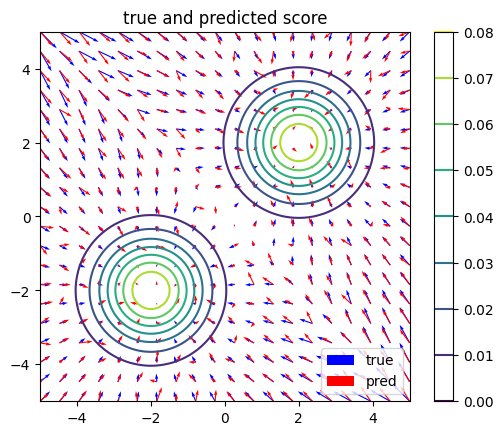

In [17]:
# 混合分布の等高線図を可視化するため、格子点の数を多くして各点の尤度を計算
# 二次元の格子点の座標を作成
num_point = 100
ls = np.linspace(-5, 5, num_point)
_x, _y = np.meshgrid(ls, ls)
_point = torch.tensor(np.vstack([_x.flatten(), _y.flatten()]).T).to(torch.float32)
# 格子点の座標における尤度を算出
p = torch.exp(dist.log_prob(_point))

# 混合分布の等高線図を可視化
plt.title('true and predicted score')
plt.contour(_x, _y, p.reshape(_x.shape))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.colorbar()

# 混合分布の実際のスコアを可視化
plt.quiver(x,y,score[:,:,0],score[:,:,1],color='blue',angles='xy',label='true')
# 学習済みモデルによって予測されたスコアを可視化
plt.quiver(x,y,pred_vec[:,:,0],pred_vec[:,:,1],color='red',angles='xy',label='pred')

plt.legend(loc='lower right')
plt.show()

### 学習済みスコアベースモデルを用いたサンプリング

In [23]:
# モデルベースのランジュバン・モンテカルロ法の実装
def model_based_langevin_monte_carlo(model, num_samples, num_steps, step_size, sigma):
    # 初期サンプルを乱数から生成
    x = torch.randn(num_samples, model.input_dim)
    # モデルを推論モードに変更
    model.eval()
    # 以下、学習済みモデルによって予測されたスコアを用いてランジュバン・モンテカルロ法を実行
    for i in tqdm(range(num_steps)):
        with torch.no_grad():
            noise = torch.normal(mean=0, std=sigma, size=x.shape)
            noise_x = x + noise
            batch_sigma = torch.ones((noise_x.shape[0], 1)) * sigma
            score = model(torch.concat([noise_x, batch_sigma], axis=1))
            noise = torch.randn(num_samples, model.input_dim)
            x = x + step_size * score + np.sqrt(2 * step_size) * noise
    return x

In [24]:
# ランジュバン・モンテカルロ法のパラメータ
num_samples = 100000
num_steps = 1000
step_size = 0.1
sigma = 1

In [25]:
# サンプリングの実行
samples = model_based_langevin_monte_carlo(model, num_samples, num_steps, step_size, sigma)

  0%|          | 0/1000 [00:00<?, ?it/s]

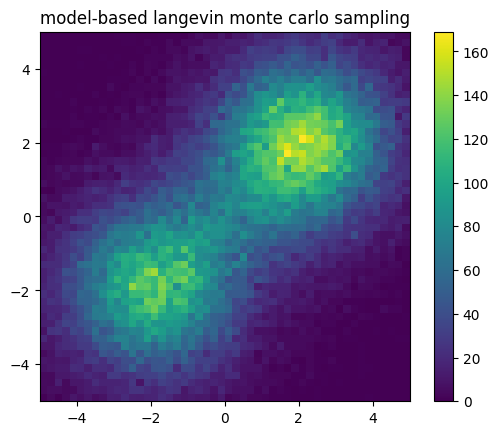

In [26]:
# サンプリング結果の可視化
plt.title('model-based langevin monte carlo sampling')
plt.hist2d(
    samples[:,0], 
    samples[:,1], 
    range=((-5, 5), (-5, 5)), 
    cmap='viridis', 
    bins=50, 
)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.colorbar()
plt.show()

### MNISTで実践